In [1]:
import numpy as np
import Derivatives as Div
import Cheb as Ch
import matplotlib.pyplot as plt

class Parent:
    x = None

class Child1(Parent):
    def __init__(self) -> None:
        self.x = [1, 2]

parent = Parent()
child = Child1()

print(parent.x)
print(child.x)
print(Parent.x)
print(Child1.x)

None
[1, 2]
None
None


Size of x:  30
Shape of D:  (30, 30)


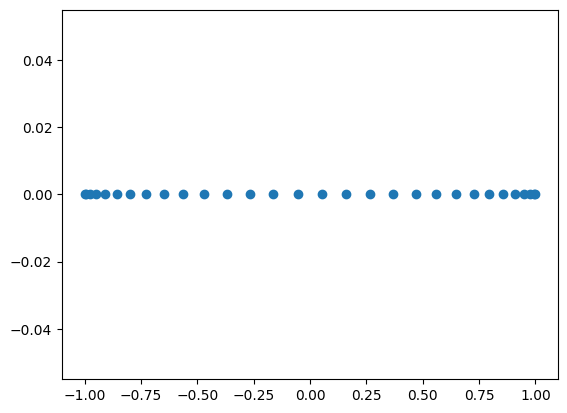

In [3]:
N = 30          # grid itself will be of size N+1
x = Ch.Grid(N, mode='cheb').grid
D = Div.DX(N).matrix

print("Size of x: ", len(x))
print("Shape of D: ", D.shape)

plt.scatter(x, [0 for i in range(N)])
plt.show()

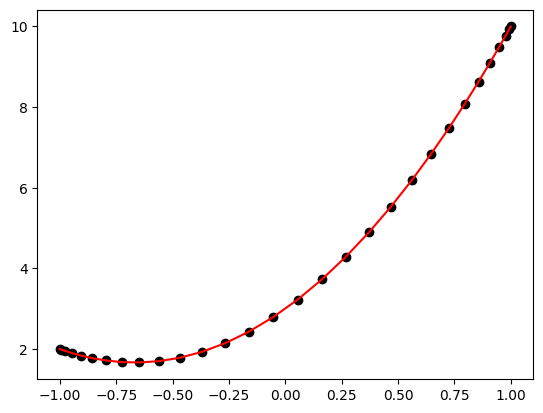

In [4]:
def poly3(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d

def poly3div(x, a, b, c, d):
    return 3*a*x*x + 2*b*x + c


a, b, c, d = 1, 2, 3, 4

ydata = [poly3(i, a, b, c, d) for i in x]   # 3rd degree polynomial values
yRef = [poly3div(i, a, b, c, d) for i in x] # true derivative
yD = D @ ydata                              # spectral derivative


plt.plot(x, yRef, 'r')
plt.scatter(x, yD, c='black')
plt.show()